In [1]:
%matplotlib inline
import os 
import sys
import numpy as np
from numpy import mean, std
import nibabel as nb 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, spearmanr,pearsonr, fisher_exact,kstest
from scipy.stats import ks_2samp, kstest, anderson, anderson_ksamp, levene
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from sklearn import preprocessing
import statsmodels.api as sm
pd.options.display.max_columns = 999
import statsmodels.formula.api as smf
import scipy.stats as ss 
import math 
from outliers import smirnov_grubbs as grubbs

plt.rcParams['font.family'] = 'Myriad Pro'
sns.set_style('white')

datadir       = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSM/FEB17'
mrsdir        = '/Users/kanaan/SCR/Dataframes_20150820/REVISION_DF'
clinical_dir  = '/Users/kanaan/SCR/Dataframes_20150820/DF_clinical/'
img_dir       = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSM/NUCLEI_FEB17'
savefigdir    = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python'

measures = ['Caud_Puta', 'Thal', 'SN', 'STN', 'RN',  'DN', 'Pall']
bigmasks = ['BrainStem','BasalGanglia', 'ALL_NUCLEI' ]

drop_c = ['WSKT','SC1T','LL5T', 'GSAT'] 
drop_p = ['AA8P', 'RA9P', 'STDP','NL2P','HSPP', 'DF2P'] 

In [2]:
def get_all_dfs(img, population, study_id, trt=False):
    quant = 'median'
    QSM = pd.read_csv(os.path.join(datadir, '%s_%s_%s_%s.csv'%(img, quant, population, study_id)),index_col = 0)
    QSM['Gender']  = QSM['Gender'].map({' F': 1, ' M': 0})
    
    CLN = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s_a.csv'%(population)), index_col=0)
    CLN.columns = ['CLN_' + str(col) for col in CLN.columns]    

    def get_mrs(vox):
        if trt == False:
            df = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_%s.csv'%(vox, population, study_id)),index_col = 0)
        elif trt == True:
            df = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_trt_%s.csv'%(vox, population, study_id)),index_col = 0)
        df.columns = ['%s_'%vox + str(col) for col in df.columns]
        return df
    df = pd.concat([QSM, get_mrs('STR'), CLN], axis=1, join_axes=[QSM.index])
    df['L_Caud_Puta']    = (df['L_Puta'] + df['L_Caud']) / 2
    df['R_Caud_Puta']    = (df['R_Puta'] + df['R_Caud']) / 2
    df['Caud_Puta']      = (df['L_Caud_Puta'] + df['R_Caud_Puta']) / 2
    df['L_BrainStem']    = (df['L_STN'] + df['L_SN'] +  df['L_RN']) / 3
    df['R_BrainStem']    = (df['R_STN'] + df['R_SN'] +  df['R_RN']) / 3
    df['L_BasalGanglia'] = (df['L_Puta'] + df['L_Caud'] +  df['L_Pall'] ) / 3
    df['R_BasalGanglia'] = (df['R_Puta'] + df['R_Caud'] +  df['R_Pall'] ) / 3
    df['L_ALL_NUCLEI'] = (df['L_BrainStem'] + df['L_BasalGanglia'] + df['L_DN']) / 3
    df['R_ALL_NUCLEI'] = (df['R_BrainStem'] + df['R_BasalGanglia'] + df['R_DN']) / 3
    df['ALL_NUCLEI'] = (df['BrainStem'] + df['BasalGanglia']) /3
    return df

controls_a = get_all_dfs('QSM', 'controls', 'a').drop(drop_c, axis = 0) 
patients_a = get_all_dfs('QSM', 'patients', 'a').drop(drop_p, axis = 0)

In [3]:
def grubbs_outliers(df, measure, alpha = 0.05):
    from outliers import smirnov_grubbs as grubbs
    return [str(i) for i in df.index if i not in grubbs.test(df[measure], alpha).index] 

def gESD_outliers(df, measure, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df[measure],maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 

In [1]:
def make_plot_all(df1,df2, m, pal= [0,3], save = None):
    sns.set(font_scale=1.5)
    sns.set_style('darkgrid', {"xtick.direction": "in","ytick.direction": "in"})
    f, (ax1,ax2,ax3,ax4,ax5,ax6)= plt.subplots(nrows = 1, ncols = 6)
    f.set_size_inches([40,10])
    pallete = sns.color_palette("hls", 6)#[pal[0]:pal[1]]
    x = 1000
                
    def make_multiplot(m,  pallete, ax, jitter = 0.1, font=30):   
        data = [df1[m]*x, df2[m]*x] 
        g = sns.violinplot( data = data, color = pallete, ax = ax,whis= 1)#, scale='count')
        g = sns.stripplot(data=data, color = pallete, jitter= jitter, ax = ax, size = 10, linewidth=1)
        g = sns.pointplot(data=data, color = pallete, linestyles=['--'], markers=['o'], ax =ax)
        #g.legend([m], fontsize = 30 , handlelength=0, loc = 2)
        g.set(xticklabels=[])  
        def annot_datapoints(df, m, xr, alpha = 0.2, ax = ax):
            for i,s in zip(df[m]* x, df.index):
                ann = ax.annotate('%s'%s, xy= (xr,i), size= 15, color='b', alpha = alpha)
        
        #annot_datapoints(df1,m, -0.4)
        #annot_datapoints(df2,m, 0.4)
        #g.set(ylim=(-50, 300))

    make_multiplot(m[0], pallete[0], ax1)
    make_multiplot(m[1], pallete[1], ax2)
    make_multiplot(m[2], pallete[2], ax3)
    make_multiplot(m[3], pallete[3], ax4)
    make_multiplot(m[4], pallete[4], ax5)
    make_multiplot(m[5], pallete[5], ax6)
    
    fname = os.path.join(savefigdir, 'stats_all.png')
    #f.savefig(fname , dpi = 300, bbox_inches='tight', transparent = False)

In [2]:
nuclei  = ['SN', 'STN', 'RN','GPi','Puta','DN']
make_plot_all(controls_a,patients_a,nuclei)

NameError: name 'controls_a' is not defined

In [5]:
def return_qsm_data(subject, nucleus):
    subdir = os.path.join(img_dir, subject)
    #qsm = np.rot90(nb.load(os.path.join(subdir, 'QSM_denoised.nii.gz')).get_data())
    qsm = np.rot90(nb.load(os.path.join(subdir, 'QSM_denoised.nii.gz')).get_data())# * - 100
    uni = np.rot90(nb.load(os.path.join(subdir, 'MP2RAGE2FLASH_BRAIN.nii.gz')).get_data()) #/  350
    
    if nucleus in ['RN','SN','STN','DN']:
        l = np.rot90(nb.load(os.path.join(subdir,'L_%s.nii.gz')%nucleus).get_data())
        r = np.rot90(nb.load(os.path.join(subdir,'R_%s.nii.gz')%nucleus).get_data())
    elif nucleus is 'Pall':
        l = np.rot90(nb.load(os.path.join(subdir,'FIRST_HYBRID-L_Pall_first_thr.nii.gz')).get_data())
        r = np.rot90(nb.load(os.path.join(subdir,'FIRST_HYBRID-R_Pall_first_thr.nii.gz')).get_data())
    elif nucleus is 'Caud_Puta':
        l = np.rot90(nb.load(os.path.join(subdir,'FIRST_HYBRID-L_Caud_first_thr.nii.gz')).get_data()) + \
            np.rot90(nb.load(os.path.join(subdir,'FIRST_HYBRID-L_Puta_first_thr.nii.gz')).get_data())
        r = np.rot90(nb.load(os.path.join(subdir,'FIRST_HYBRID-R_Caud_first_thr.nii.gz')).get_data()) + \
            np.rot90(nb.load(os.path.join(subdir,'FIRST_HYBRID-R_Puta_first_thr.nii.gz')).get_data())
    l[l==0]=np.nan
    r[r==0]=np.nan
    return qsm,uni,l,r      

def edge_detect_ero(i):
    ero  = ndimage.binary_erosion(i,iterations=1).astype(i.dtype)
    edge = i - ero
    edge[edge==0]=np.nan
    return edge

def edge_detect_first(i):
    ero =  ndimage.binary_erosion(i, iterations=2).astype(i.dtype)
    dil =  ndimage.binary_dilation(i, iterations=1).astype(i.dtype)
    sep = dil-ero
    sep = ndimage.binary_erosion(sep, iterations=1).astype(sep.dtype)
    sep[sep==0]=np.nan
    return sep

def make_split_df(dfx, group, measure, hemi):
    df = pd.DataFrame(columns = [measure, 'Population', 'Hemisphere'])
    df[measure]      = dfx['%s_%s'%(hemi[0], measure)] *1000
    df['Hemisphere'] = hemi
    df['Population'] = group
    return df

In [26]:
measures = ['RN','SN','STN','Caud_Puta','Pall','DN']
Brainstem =  ['SN','STN',]
Basalganglia = ['Caud_Puta','Pall','DN']
red = ['RN']


lims = {'cor_x': (45, 160), 'cor_y': (140,10), 'ax_x': (35, 170), 'ax_y':(200,50)}
Zcuts = { 'RN':41, 'STN':130, 'SN':130, 'Pall':64, 'Caud_Puta': 64, 'DN':20}

sns.set(font_scale=2)
sns.set_style('darkgrid', {"xtick.direction": "in","ytick.direction": "in"})
palette = sns.color_palette("hls", 24)

def make_split_plot(measures,df1,df2, save = 0 ):
    fig = plt.figure()
    fig.set_size_inches(40, 20)
    fig.subplots_adjust(left=None, bottom=None, 
                        right=None, top=None, wspace=None, hspace=None)

    #left  = 0.125  # the left side of the subplots of the figure
    #right = 0.9    # the right side of the subplots of the figure
    #bottom = 0.1   # the bottom of the subplots of the figure
    #top = 0.9      # the top of the subplots of the figure
    #wspace = 0.2   # the amount of width reserved for blank space between subplots
    #hspace = 0.2   # the amount of height reserved for white space between subplots

    x = 1000
    for i, measure in enumerate(measures): 
        c = i 
        c += i*3
        print measure, c 
        ax1 = plt.subplot2grid((2,6),(1,i), colspan=1,rowspan=1)
        data = [df1[measure]*x, df2[measure]*x] 
        df = pd.concat([make_split_df(df1, 'Controls', measure,'Left'),make_split_df(df1, 'Controls', measure,'Right'),
                        make_split_df(df2, 'Patients', measure,'Left'),make_split_df(df2, 'Patients', measure,'Right')])
        g = sns.stripplot(data=data, ax = ax1, color = palette[c+2] ,
                          jitter= 0.1, size = 10, linewidth=1)
        g = sns.pointplot(data=data, ax = ax1, color = palette[c+2] ,
                          linestyles=['--'], markers=['o'], )        
        g = sns.violinplot(x='Population', y = measure, hue= 'Hemisphere', split=1,  
                           data=df, ax = ax1, inner= 'quart',
                           palette ={'Left': palette[c],'Right': palette[c+1] })
        g.set(xticklabels=[])  
        g.set(xlabel=' ',ylabel=' ')
        plt.legend(loc='upper left')
        #g.legend_.remove()
        ####################################################
        
        qsm, uni, l, r = return_qsm_data('BATP', measure)
        qsm2, uni2, l2, r2 = return_qsm_data('PAHT', measure)
        Zcut =Zcuts[measure]
        ax2 = plt.subplot2grid((2,6),(0,i), colspan=1,rowspan=1)
        
        if measure in Brainstem:
            print measure
            ax2.imshow(np.rot90(qsm[Zcut,:,:]), interpolation= None, alpha = 1,vmin = -.25, vmax = 0.25)
            ax2.imshow(np.rot90(uni[Zcut,:,:]), interpolation= None, alpha = 0.5)
            ax2.imshow(np.rot90(l[Zcut,:,:]), interpolation= None, cmap= ListedColormap(palette[c]))
            ax2.imshow(np.rot90(r[Zcut,:,:]), interpolation= None, cmap= ListedColormap(palette[c+1]))
            ax2.set_xlim(lims['cor_x'][0],lims['cor_x'][1])
            ax2.set_ylim(lims['cor_y'][0],lims['cor_y'][1])
        elif measure in red:
            ax2.imshow(qsm2[:,:,Zcut], interpolation= None, alpha = 1,vmin = -.25, vmax = 0.25)
            ax2.imshow(uni2[:,:,Zcut], interpolation= None, alpha = 0.5)
            ax2.imshow(l2[:,:,Zcut], interpolation= None, cmap= ListedColormap(palette[c]))
            ax2.imshow(r2[:,:,Zcut], interpolation= None, cmap= ListedColormap(palette[c+1]))
            ax2.set_xlim(35, 170)
            ax2.set_ylim(200,50)
            
        elif measure in Basalganglia:
            print measure
            ax2.imshow(qsm[:,:,Zcut], interpolation= None, alpha = 1,vmin = -.25, vmax = 0.25)
            ax2.imshow(uni[:,:,Zcut], interpolation= None, alpha = 0.5)#,vmin = -.3, vmax = 0.
            ax2.imshow(l[:,:,Zcut], interpolation= None, cmap= ListedColormap(palette[c]))
            ax2.imshow(r[:,:,Zcut], interpolation= None, cmap= ListedColormap(palette[c+1]))
            if measure == 'DN':
                ax2.set_xlim(35, 170)
                ax2.set_ylim(230,80)
            else:    
                ax2.set_xlim(lims['ax_x'][0],lims['ax_x'][1])
                ax2.set_ylim(lims['ax_y'][0],lims['ax_y'][1])
        ax2.set_xticklabels = []
        ax2.set_yticklabels = []
        ax2.axes.get_yaxis().set_visible(False)
        ax2.axes.get_xaxis().set_visible(False)
        ax2.grid(False)
        ax2.tick_params(axis='x', labelsize=5)
        ax2.tick_params(axis='y', labelsize=25)
    
    plt.tight_layout()
    if save:
        fig.savefig(os.path.join(savefigdir, 'stats_all_splitv2.png'),
                    dpi = 100, bbox_inches='tight', transparent = False)


RN 0
SN 4
SN
STN 8
STN
Caud_Puta 12
Caud_Puta
Pall 16
Pall
DN 20
DN


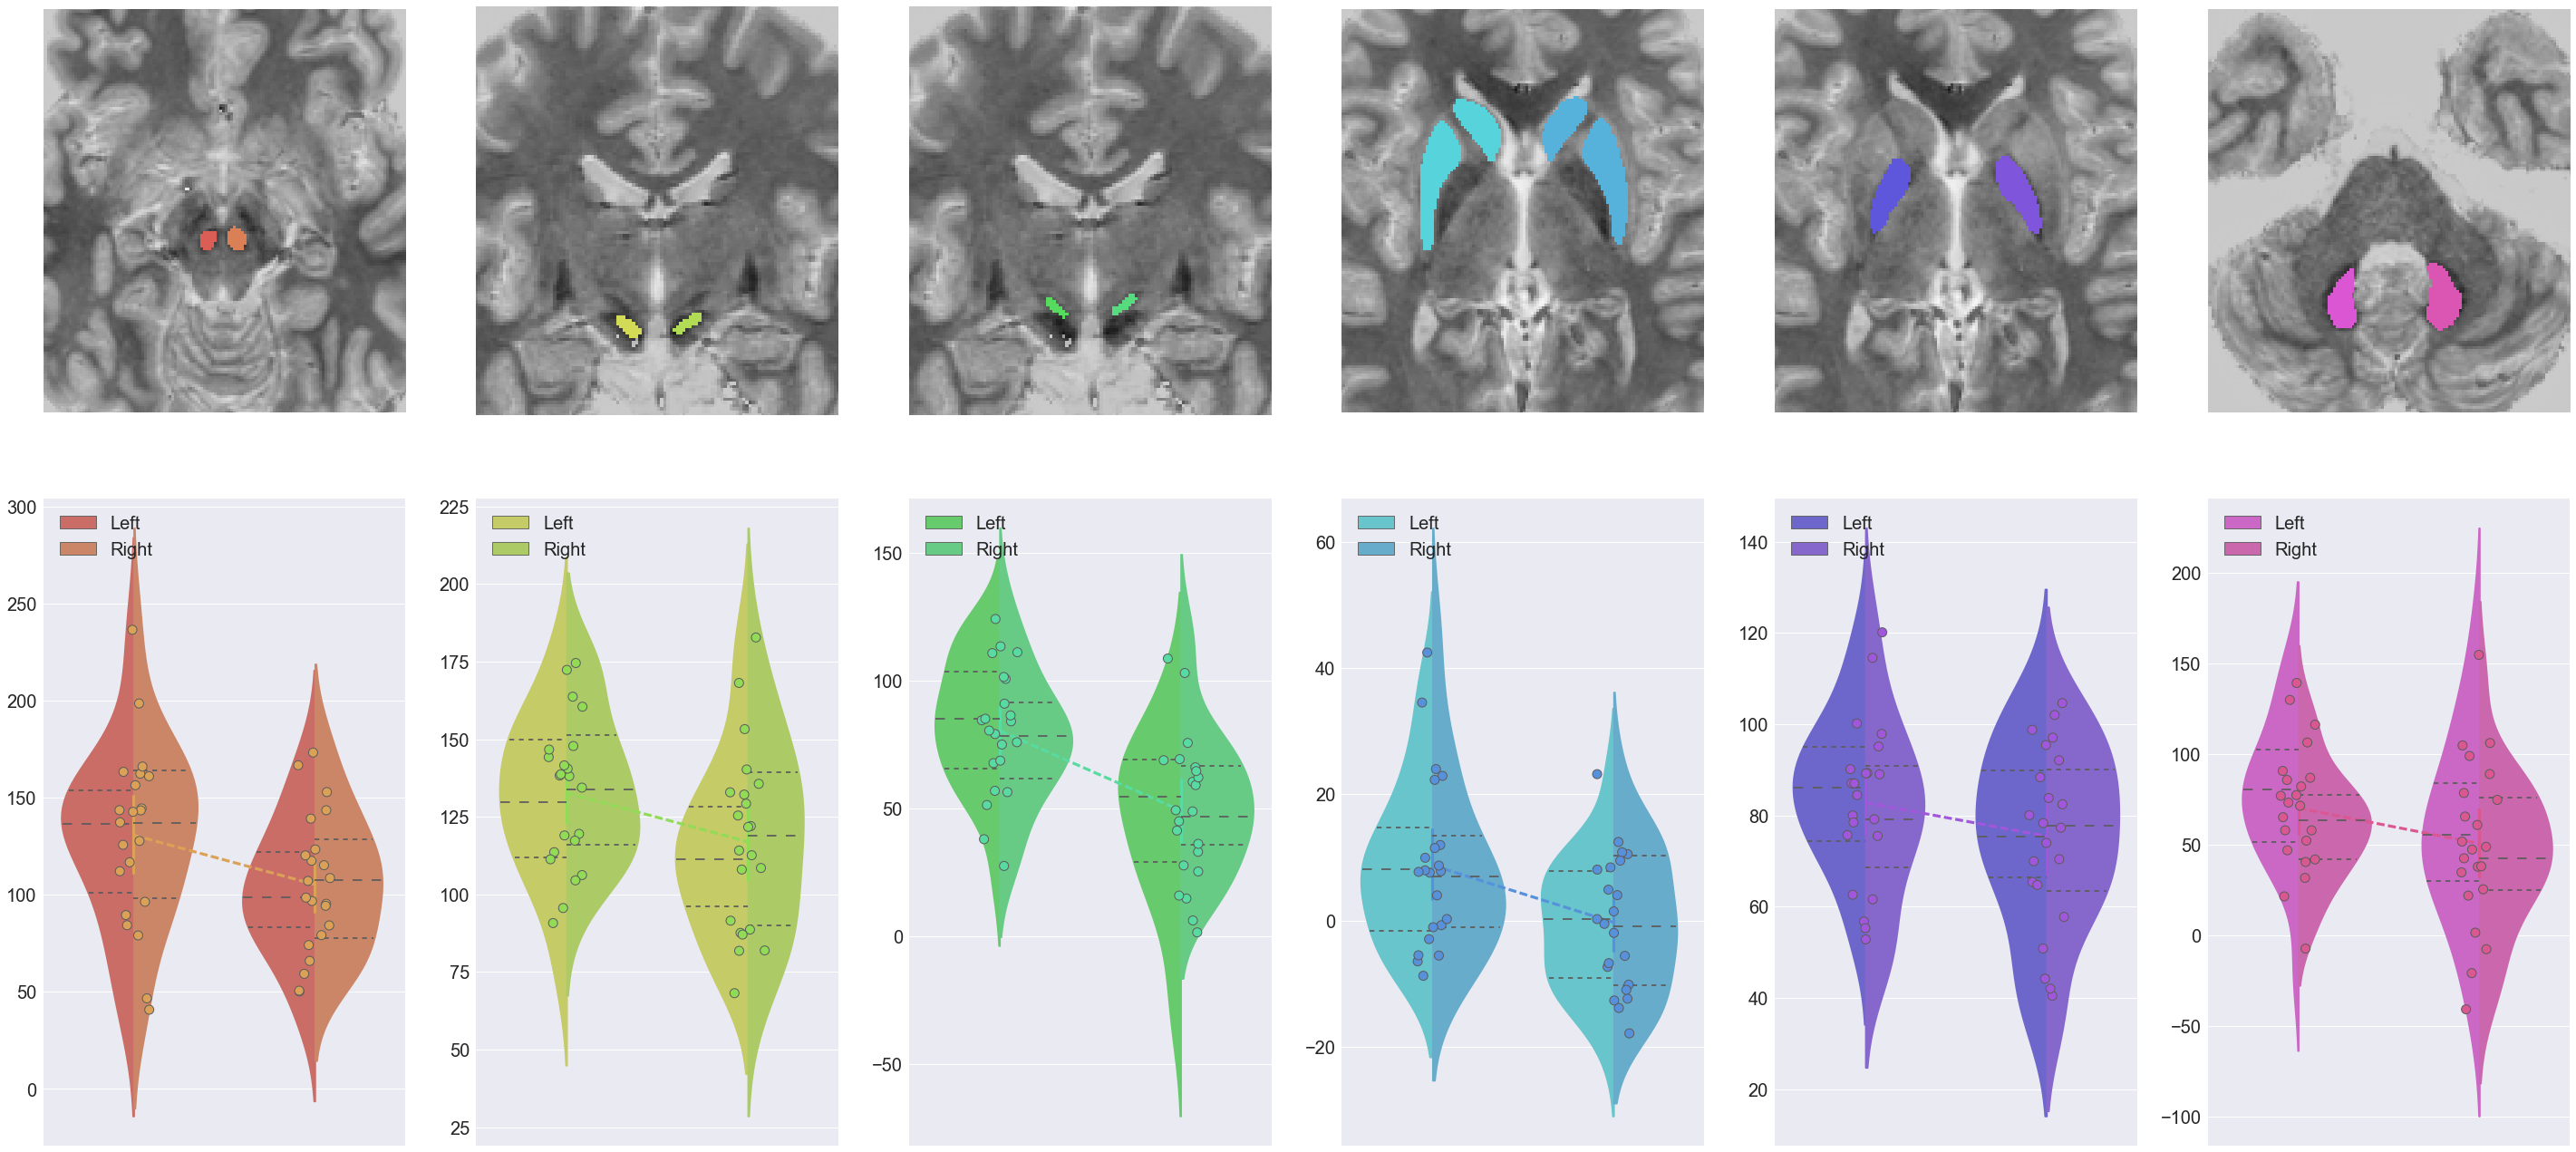

In [27]:
make_split_plot(measures,controls_a,patients_a, save = 1)

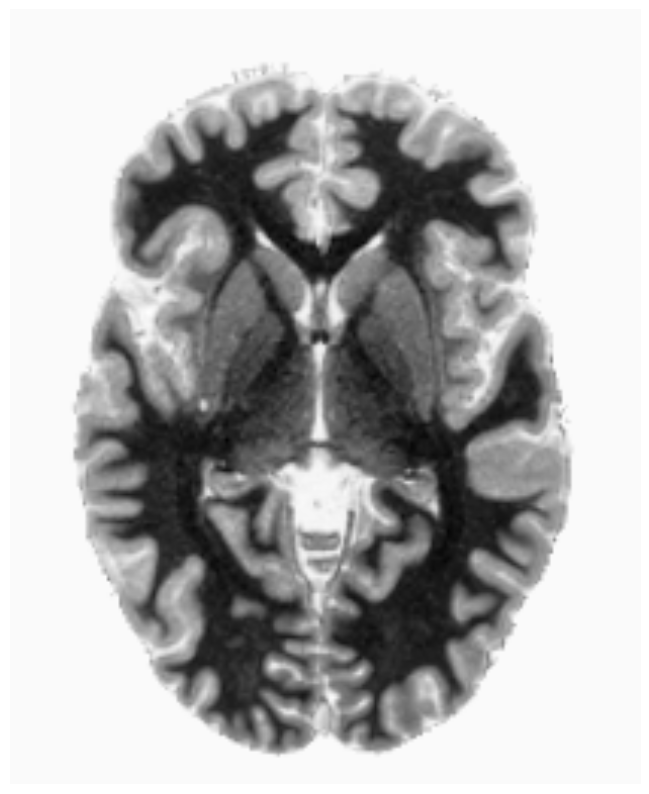

In [311]:
subdir = os.path.join(img_dir, 'PAHT')
qsm = np.rot90(nb.load(os.path.join(subdir, 'QSM_denoised.nii.gz')).get_data()) *  1000
uni = np.rot90(nb.load(os.path.join(subdir, 'HYBRID_CONTRAST_IMAGE.nii.gz')).get_data()) *  0.5
rn = np.rot90(nb.load(os.path.join(subdir, 'L_RN.nii.gz')).get_data()) + np.rot90(nb.load(os.path.join(subdir, 'r_RN.nii.gz')).get_data()) #/  350
sn = np.rot90(nb.load(os.path.join(subdir, 'L_SN.nii.gz')).get_data()) + np.rot90(nb.load(os.path.join(subdir, 'r_SN.nii.gz')).get_data()) #/  350
stn = np.rot90(nb.load(os.path.join(subdir, 'L_STN.nii.gz')).get_data()) + np.rot90(nb.load(os.path.join(subdir, 'r_STN.nii.gz')).get_data()) #/  350
rn[rn==0]=np.nan
sn[sn==0]=np.nan
stn[stn==0]=np.nan

fig = plt.figure()
fig.set_size_inches(10,10)
ax = plt.axes(frameon=False)
z = 55
ax.imshow(qsm[:,:,z], interpolation= None, alpha = 1)#,vmin = -.25, vmax = 0.25)
ax.imshow(uni[:,:,z], interpolation= None, alpha = 1)
ax.imshow(rn[:,:,z], interpolation= None, alpha = 1)

ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)


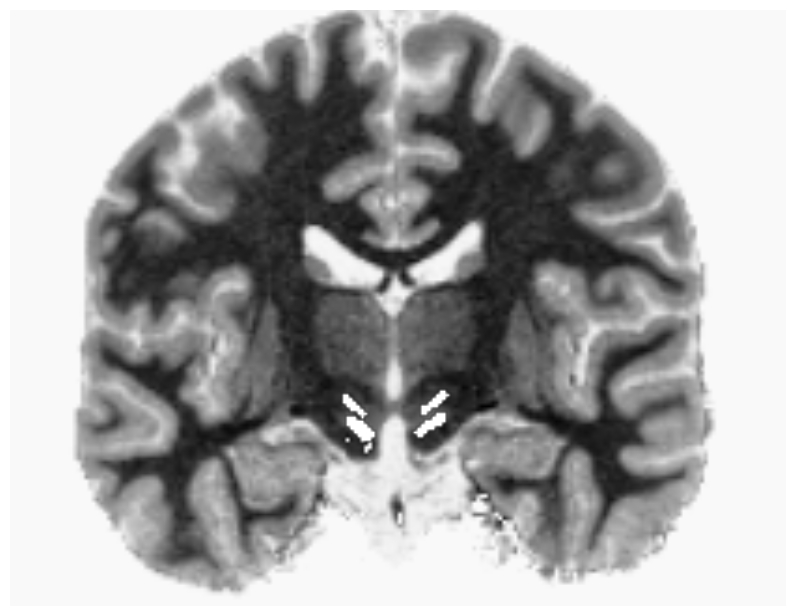

In [306]:
subdir = os.path.join(img_dir, 'BATP')
qsm = np.rot90(nb.load(os.path.join(subdir, 'QSM_denoised.nii.gz')).get_data()) #*  100
uni = np.rot90(nb.load(os.path.join(subdir, 'HYBRID_CONTRAST_IMAGE.nii.gz')).get_data()) /1250  
rn = np.rot90(nb.load(os.path.join(subdir, 'L_RN.nii.gz')).get_data()) + np.rot90(nb.load(os.path.join(subdir, 'r_RN.nii.gz')).get_data()) #/  350
sn = np.rot90(nb.load(os.path.join(subdir, 'L_SN.nii.gz')).get_data()) + np.rot90(nb.load(os.path.join(subdir, 'r_SN.nii.gz')).get_data()) #/  350
stn = np.rot90(nb.load(os.path.join(subdir, 'L_STN.nii.gz')).get_data()) + np.rot90(nb.load(os.path.join(subdir, 'r_STN.nii.gz')).get_data()) #/  350
rn[rn==0]=np.nan
sn[sn==0]=np.nan
stn[stn==0]=np.nan


fig = plt.figure()
fig.set_size_inches(10,10)
ax = plt.axes(frameon=False)
z = 130
ax.imshow(np.rot90(qsm[z,:,:]), interpolation= None, alpha = 1,vmin = -.25, vmax = 0.25)
ax.imshow(np.rot90(uni[z,:,:]), interpolation= None, alpha = 1)
ax.imshow(np.rot90(sn[z,:,:]), interpolation= None, alpha = 1)
ax.imshow(np.rot90(stn[z,:,:]), interpolation= None, alpha = 1)


ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)


